<a href="https://colab.research.google.com/github/Nandan0402/sales-forecasting-linear-regression-ml/blob/main/Sales_Prediction_using_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [92]:
import os

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [94]:
store_sales = pd.read_csv('train.csv')
store_sales.head(10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


In [95]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590669 entries, 0 to 590668
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    590669 non-null  object
 1   store   590669 non-null  int64 
 2   item    590669 non-null  int64 
 3   sales   590669 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 18.0+ MB


In [96]:
store_sales = store_sales.drop(['store','item'],axis=1)

In [97]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590669 entries, 0 to 590668
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    590669 non-null  object
 1   sales   590669 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 9.0+ MB


In [98]:
store_sales['date'] = pd.to_datetime(store_sales['date'], errors='coerce')
store_sales = store_sales.dropna(subset=['date'])

In [99]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590669 entries, 0 to 590668
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    590669 non-null  datetime64[ns]
 1   sales   590669 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 9.0 MB


In [100]:
store_sales['date'] = store_sales['date'].dt.to_period('M')
monthly_sales = store_sales.groupby('date').sum().reset_index()

In [101]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

In [102]:
monthly_sales.head(10)

,date,sales
0,2013-01-01,309282
1,2013-02-01,312796
2,2013-03-01,419394
3,2013-04-01,463483
4,2013-05-01,518686
5,2013-06-01,540649
6,2013-07-01,581406
7,2013-08-01,521356
8,2013-09-01,468366
9,2013-10-01,446414


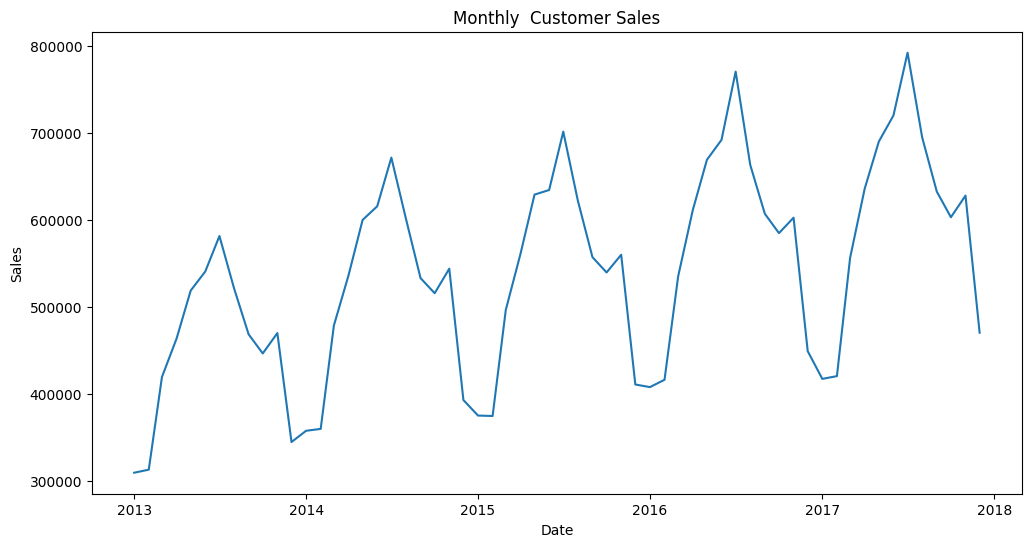

In [103]:
plt.figure(figsize=(12,6))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Monthly  Customer Sales')
plt.show()

In [104]:
monthly_sales['sales'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,date,sales
1,2013-02-01,3514.0
2,2013-03-01,106598.0
3,2013-04-01,44089.0
4,2013-05-01,55203.0
5,2013-06-01,21963.0
6,2013-07-01,40757.0
7,2013-08-01,-60050.0
8,2013-09-01,-52990.0
9,2013-10-01,-21952.0
10,2013-11-01,23437.0


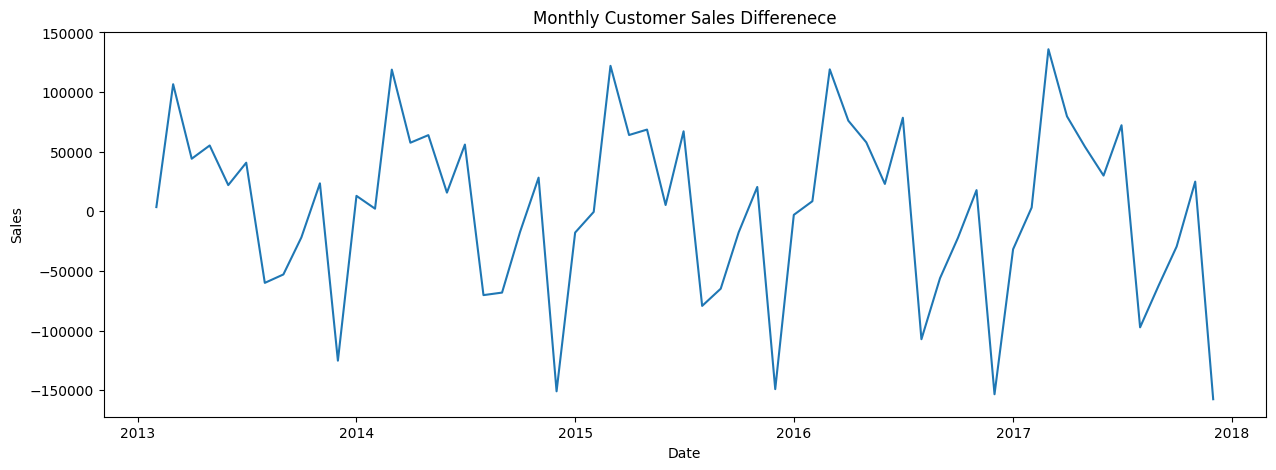

In [105]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Monthly Customer Sales Differenece')
plt.show()

In [106]:
supervised_data = monthly_sales[['sales']]

In [107]:
for i in range (1,13):
  col_name = 'month' + str(i)
  supervised_data[col_name] = supervised_data['sales'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,sales,month1,month2,month3,month4,month5,month6,month7,month8,month9,month10,month11,month12
0,2185.0,12935.0,-125291.0,23437.0,-21952.0,-52990.0,-60050.0,40757.0,21963.0,55203.0,44089.0,106598.0,3514.0
1,118847.0,2185.0,12935.0,-125291.0,23437.0,-21952.0,-52990.0,-60050.0,40757.0,21963.0,55203.0,44089.0,106598.0
2,57525.0,118847.0,2185.0,12935.0,-125291.0,23437.0,-21952.0,-52990.0,-60050.0,40757.0,21963.0,55203.0,44089.0
3,63869.0,57525.0,118847.0,2185.0,12935.0,-125291.0,23437.0,-21952.0,-52990.0,-60050.0,40757.0,21963.0,55203.0
4,15657.0,63869.0,57525.0,118847.0,2185.0,12935.0,-125291.0,23437.0,-21952.0,-52990.0,-60050.0,40757.0,21963.0
5,55965.0,15657.0,63869.0,57525.0,118847.0,2185.0,12935.0,-125291.0,23437.0,-21952.0,-52990.0,-60050.0,40757.0
6,-70315.0,55965.0,15657.0,63869.0,57525.0,118847.0,2185.0,12935.0,-125291.0,23437.0,-21952.0,-52990.0,-60050.0
7,-68201.0,-70315.0,55965.0,15657.0,63869.0,57525.0,118847.0,2185.0,12935.0,-125291.0,23437.0,-21952.0,-52990.0
8,-17389.0,-68201.0,-70315.0,55965.0,15657.0,63869.0,57525.0,118847.0,2185.0,12935.0,-125291.0,23437.0,-21952.0
9,28225.0,-17389.0,-68201.0,-70315.0,55965.0,15657.0,63869.0,57525.0,118847.0,2185.0,12935.0,-125291.0,23437.0


In [108]:
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]
print("Train Data shape",train_data.shape)
print("Test Data shape",test_data.shape)

Train Data shape (35, 13)
Test Data shape (12, 13)


In [109]:
scalar = MinMaxScaler(feature_range=(-1,1))
scalar.fit(train_data)
train_data = scalar.transform(train_data)
test_data = scalar.transform(test_data)

In [110]:
x_train , y_train = train_data[:,1:],train_data[:,0]
x_test , y_test = test_data[:,1:],test_data[:,0:1]
y_test = y_test.ravel()
print("X_train shape",x_train.shape)
print("Y_train shape",y_train.shape)
print("X_test shape",x_test.shape)
print("Y_test shape",y_test.shape)

X_train shape (35, 12)
Y_train shape (35,)
X_test shape (12, 12)
Y_test shape (12,)


In [111]:
sale_date = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sale_date)

In [112]:
act_sales = monthly_sales['sales'][-13:].to_list()
print(act_sales)

[-153471.0, -31852.0, 3148.0, 135940.0, 79614.0, 54119.0, 29950.0, 72188.0, -97333.0, -62240.0, -29574.0, 24897.0, -157637.0]


In [113]:
lr_model = LinearRegression()
lr_model.fit(x_train,y_train)
lr_pred = lr_model.predict(x_test)

In [114]:
# To inverse transform the predictions (lr_pred):
# Create a temporary array of the shape of `test_data` to match the scaler's input dimensions
dummy_for_lr_pred = np.zeros_like(test_data)
# Place the predictions (lr_pred) into the target column (index 0)
dummy_for_lr_pred[:, 0] = lr_pred
# Place the features (x_test) into the feature columns (index 1 onwards)
dummy_for_lr_pred[:, 1:] = x_test
# Inverse transform the dummy array
lr_pred_original_scale_full = scalar.inverse_transform(dummy_for_lr_pred)
# Extract the inverse transformed predictions (which are now in original scale differences)
lr_pred_diff = lr_pred_original_scale_full[:, 0]


# To inverse transform the actuals (y_test):
dummy_for_y_test = np.zeros_like(test_data)
dummy_for_y_test[:, 0] = y_test
dummy_for_y_test[:, 1:] = x_test
y_test_diff_full = scalar.inverse_transform(dummy_for_y_test)
y_test_diff = y_test_diff_full[:, 0]

In [115]:
predict_df['Linear Prediction'] = lr_pred_diff

In [116]:
lr_rmse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], y_test_diff))
lr_mae = mean_absolute_error(predict_df['Linear Prediction'], y_test_diff)
lr_r2 = r2_score(predict_df['Linear Prediction'], y_test_diff)
print("Linear Regression MSE:",lr_rmse)
print("Linear Regression MAE:",lr_mae)
print("Linear Regression R2:",lr_r2)

Linear Regression MSE: 11433.009201277959
Linear Regression MAE: 8693.608886956363
Linear Regression R2: 0.9803700897380774


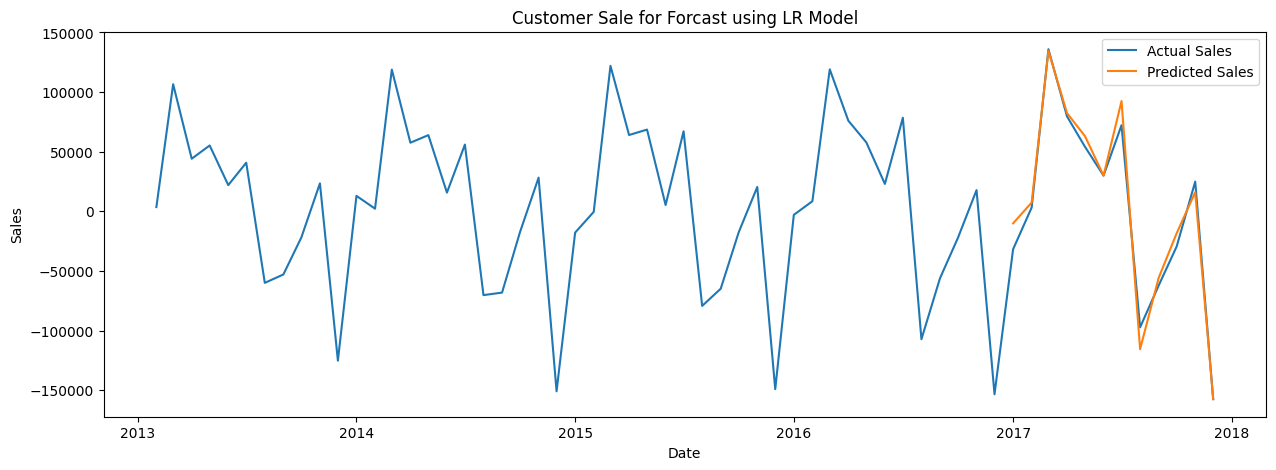

In [117]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.plot(predict_df['date'],predict_df['Linear Prediction'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Customer Sale for Forcast using LR Model')
plt.legend(['Actual Sales','Predicted Sales'])
plt.show()

# Task
```python
rf_model = RandomForestRegressor(n_estimators=100,random_state=42)
rf_model.fit(x_train,y_train)
rf_pred = rf_model.predict(x_test)
```
```python
# To inverse transform the predictions (rf_pred):
# Create a temporary array of the shape of `test_data` to match the scaler's input dimensions
dummy_for_rf_pred = np.zeros_like(test_data)
# Place the predictions (rf_pred) into the target column (index 0)
dummy_for_rf_pred[:, 0] = rf_pred
# Place the features (x_test) into the feature columns (index 1 onwards)
dummy_for_rf_pred[:, 1:] = x_test
# Inverse transform the dummy array
rf_pred_original_scale_full = scalar.inverse_transform(dummy_for_rf_pred)
# Extract the inverse transformed predictions (which are now in original scale differences)
rf_pred_diff = rf_pred_original_scale_full[:, 0]
predict_df['RandomForest Prediction'] = rf_pred_diff
```
```python
rf_rmse = np.sqrt(mean_squared_error(predict_df['RandomForest Prediction'],y_test_diff))
rf_mae = mean_absolute_error(predict_df['RandomForest Prediction'],y_test_diff)
rf_r2 = r2_score(predict_df['RandomForest Prediction'],y_test_diff)
print("RandomForest Regression RMSE:",rf_rmse)
print("RandomForest Regression MAE:",rf_mae)
print("RandomForest Regression R2:",rf_r2)
```

In [118]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(x_train,y_train)
rf_pred = rf_model.predict(x_test)

dummy_for_rf_pred = np.zeros_like(test_data)
dummy_for_rf_pred[:, 0] = rf_pred
dummy_for_rf_pred[:, 1:] = x_test
rf_pred_original_scale_full = scalar.inverse_transform(dummy_for_rf_pred)
rf_pred_diff = rf_pred_original_scale_full[:, 0]

predict_df['RandomForest Prediction'] = rf_pred_diff

rf_rmse = np.sqrt(mean_squared_error(predict_df['RandomForest Prediction'], y_test_diff))
rf_mae = mean_absolute_error(predict_df['RandomForest Prediction'], y_test_diff)
rf_r2 = r2_score(predict_df['RandomForest Prediction'], y_test_diff)

print("RandomForest Regressor RMSE:",rf_rmse)
print("RandomForest Regressor MAE:",rf_mae)
print("RandomForest Regressor R2:",rf_r2)

RandomForest Regressor RMSE: 12562.87005172714
RandomForest Regressor MAE: 10039.749999999982
RandomForest Regressor R2: 0.9698982761416891


In [119]:
x_train_lstm = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test_lstm = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(x_train_lstm.shape[1], 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_lstm_model.h5', monitor='val_loss', save_best_only=True)

# Train the LSTM model
lstm_model.fit(x_train_lstm, y_train, epochs=50, batch_size=1, validation_data=(x_test_lstm, y_test), callbacks=[early_stopping, model_checkpoint], verbose=0)

# Make predictions
lstm_pred = lstm_model.predict(x_test_lstm)

# Inverse transform the LSTM predictions
dummy_for_lstm_pred = np.zeros_like(test_data)
dummy_for_lstm_pred[:, 0] = lstm_pred.flatten() # Flatten lstm_pred to match dimensions
dummy_for_lstm_pred[:, 1:] = x_test
lstm_pred_original_scale_full = scalar.inverse_transform(dummy_for_lstm_pred)
lstm_pred_diff = lstm_pred_original_scale_full[:, 0]

# Add predictions to predict_df
predict_df['LSTM Prediction'] = lstm_pred_diff

# Evaluate LSTM model
lstm_rmse = np.sqrt(mean_squared_error(predict_df['LSTM Prediction'], y_test_diff))
lstm_mae = mean_absolute_error(predict_df['LSTM Prediction'], y_test_diff)
lstm_r2 = r2_score(predict_df['LSTM Prediction'], y_test_diff)

print("LSTM RMSE:", lstm_rmse)
print("LSTM MAE:", lstm_mae)
print("LSTM R2:", lstm_r2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
LSTM RMSE: 11818.245135895444
LSTM MAE: 9256.946162472172
LSTM R2: 0.9764508210223909


In [120]:
x_train_lstm = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test_lstm = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(x_train_lstm.shape[1], 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_lstm_model.keras', monitor='val_loss', save_best_only=True)

# Train the LSTM model
lstm_model.fit(x_train_lstm, y_train, epochs=50, batch_size=1, validation_data=(x_test_lstm, y_test), callbacks=[early_stopping, model_checkpoint], verbose=0)

# Make predictions
lstm_pred = lstm_model.predict(x_test_lstm)

# Inverse transform the LSTM predictions
dummy_for_lstm_pred = np.zeros_like(test_data)
dummy_for_lstm_pred[:, 0] = lstm_pred.flatten() # Flatten lstm_pred to match dimensions
dummy_for_lstm_pred[:, 1:] = x_test
lstm_pred_original_scale_full = scalar.inverse_transform(dummy_for_lstm_pred)
lstm_pred_diff = lstm_pred_original_scale_full[:, 0]

# Add predictions to predict_df
predict_df['LSTM Prediction'] = lstm_pred_diff

# Evaluate LSTM model
lstm_rmse = np.sqrt(mean_squared_error(predict_df['LSTM Prediction'], y_test_diff))
lstm_mae = mean_absolute_error(predict_df['LSTM Prediction'], y_test_diff)
lstm_r2 = r2_score(predict_df['LSTM Prediction'], y_test_diff)

print("LSTM RMSE:", lstm_rmse)
print("LSTM MAE:", lstm_mae)
print("LSTM R2:", lstm_r2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
LSTM RMSE: 12400.966031922657
LSTM MAE: 9673.070669211445
LSTM R2: 0.9744288844958219


In [121]:
from tensorflow.keras import Input

x_train_lstm = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test_lstm = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(Input(shape=(x_train_lstm.shape[1], 1)))
lstm_model.add(LSTM(50, activation='relu'))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_lstm_model.keras', monitor='val_loss', save_best_only=True)

# Train the LSTM model
lstm_model.fit(x_train_lstm, y_train, epochs=50, batch_size=1, validation_data=(x_test_lstm, y_test), callbacks=[early_stopping, model_checkpoint], verbose=0)

# Make predictions
lstm_pred = lstm_model.predict(x_test_lstm)

# Inverse transform the LSTM predictions
dummy_for_lstm_pred = np.zeros_like(test_data)
dummy_for_lstm_pred[:, 0] = lstm_pred.flatten() # Flatten lstm_pred to match dimensions
dummy_for_lstm_pred[:, 1:] = x_test
lstm_pred_original_scale_full = scalar.inverse_transform(dummy_for_lstm_pred)
lstm_pred_diff = lstm_pred_original_scale_full[:, 0]

# Add predictions to predict_df
predict_df['LSTM Prediction'] = lstm_pred_diff

# Evaluate LSTM model
lstm_rmse = np.sqrt(mean_squared_error(predict_df['LSTM Prediction'], y_test_diff))
lstm_mae = mean_absolute_error(predict_df['LSTM Prediction'], y_test_diff)
lstm_r2 = r2_score(predict_df['LSTM Prediction'], y_test_diff)

print("LSTM RMSE:", lstm_rmse)
print("LSTM MAE:", lstm_mae)
print("LSTM R2:", lstm_r2)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
LSTM RMSE: 12403.138317474199
LSTM MAE: 10047.215387251224
LSTM R2: 0.975061452624664


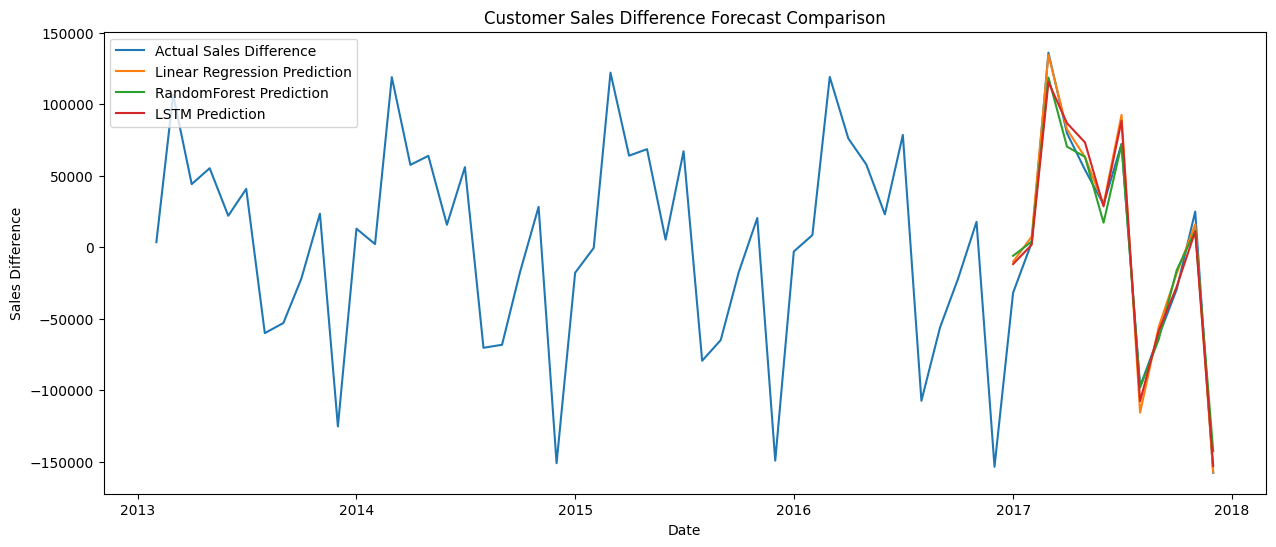

In [122]:
plt.figure(figsize=(15, 6))
plt.plot(monthly_sales['date'], monthly_sales['sales'], label='Actual Sales Difference')
plt.plot(predict_df['date'], predict_df['Linear Prediction'], label='Linear Regression Prediction')
plt.plot(predict_df['date'], predict_df['RandomForest Prediction'], label='RandomForest Prediction')
plt.plot(predict_df['date'], predict_df['LSTM Prediction'], label='LSTM Prediction')
plt.xlabel('Date')
plt.ylabel('Sales Difference')
plt.title('Customer Sales Difference Forecast Comparison')
plt.legend()
plt.show()